In [1]:
# script to combine summary urban form stats for all cities
# last edit Nov 20 2023 Peter Berrill

# load required libraries
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
from shapely.wkt import loads,dumps
from shapely import speedups
from shapely.geometry import Point, LineString, Polygon
speedups.enable()
from pyproj import CRS
from pysal.lib import weights
import pickle
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from citymob import import_csv_w_wkt_to_gdf
import networkx as nx
import osmnx as ox
import seaborn as sns
from sklearn.metrics import r2_score
crs0=3035

In [5]:
df_summ=pd.read_csv('../outputs/summary_stats/summary_UF_all_urb.csv',encoding='latin-1')


In [6]:
# now get mobility summary stats
city='Berlin'
df=pd.read_csv('../outputs/summary_stats/Berlin_stats.csv')
df['City']=city
df_all=df.copy()

for city in ['Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien']:
    df=pd.read_csv('../outputs/summary_stats/' + city + '_stats.csv')
    df['City']=city
    df_all=pd.concat([df_all,df])
df_all['City']=df_all['City'].replace('Wien','Vienna')

In [7]:
summ_UF= df_summ  
summ_UF.rename(columns={'cities':'City'},inplace=True)
summ_UF['Pop.']=summ_UF['Population'].replace(',','',regex=True).astype(int)*1e-6
summ_UF['City']=summ_UF['City'].replace('Wien','Vienna')
summ_UF.loc[:,['Pop. density','UrbPop Density']]=0.01*summ_UF.loc[:,['Pop. density','UrbPop Density']]
summ_UF.head()

,City,Population,Area,Pop. density,Built-up Density,Dist. to center,Dist. to subcenter,Intersec. Density,Street length avg.,Cycle lane share,Urban fabric area,Comm. area,Transit accessibility,Pop,Urban area,UrbPop Density,Pop.
0,Berlin,3748148,891.177023,42.058400,1.099656,8.501587,2.365113,23.649297,144.011945,5.17,25.237160,10.365251,42.134284,3.748148,0.684440,61.449355,3.748148
1,Dresden,565461,328.261060,17.225954,0.544454,4.417224,2.948257,18.055751,140.135237,8.41,14.411046,7.430500,36.464499,0.565461,0.438014,39.327440,0.565461
2,Düsseldorf,642247,215.248167,29.837513,1.071483,4.599795,2.555426,27.558887,117.115021,8.82,19.800080,13.654648,31.511716,0.642247,0.588414,50.708410,0.642247
3,Frankfurt am Main,747318,251.287907,29.739513,0.299093,5.217463,2.187848,27.677779,121.508015,17.06,12.253403,12.084123,22.165990,0.747318,0.592050,50.231430,0.747318
4,Kassel,204927,108.101396,18.956924,0.138494,3.085375,2.655072,25.577838,124.848445,4.50,18.994395,9.457040,13.922025,0.204927,0.581253,32.613880,0.204927


In [8]:
df_all=df_all.merge(summ_UF.loc[:,['City','Population','Dist. to center','Pop. density','UrbPop Density','Pop.']])
df_all.sort_values(by='Pop. density',ascending=False,inplace=True)
df_all['Mode_Share']=df_all['Mode_Share']*100
df_all.head()

,Mode,Daily_Travel_cap,Mode_Share,Ownership,Avg_trip_dist,City,Population,Dist. to center,Pop. density,UrbPop Density,Pop.
107,Car,4.693219,40.231334,0.612123,NaN,Paris,6902389,6.71893,84.663148,96.514261,6.902389
106,Bike,0.147856,1.267453,NaN,NaN,Paris,6902389,6.71893,84.663148,96.514261,6.902389
110,All,11.665582,NaN,NaN,3.267682,Paris,6902389,6.71893,84.663148,96.514261,6.902389
109,Transit,5.818354,49.876244,NaN,NaN,Paris,6902389,6.71893,84.663148,96.514261,6.902389
108,Foot,0.704565,6.039688,NaN,NaN,Paris,6902389,6.71893,84.663148,96.514261,6.902389


In [9]:
df_car_travel=df_all.loc[df_all['Mode']=='Car',]
df_car_travel['Country']='Germany'
df_car_travel.loc[df_car_travel['City'].isin(['Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse']),'Country']='France'
df_car_travel.loc[df_car_travel['City']=='Madrid','Country']='Spain'
df_car_travel.loc[df_car_travel['City']=='Vienna','Country']='Austria'
df_car_travel.reset_index(inplace=True,drop=True)
df_car_travel.head()

C:\Users\peter\AppData\Local\Temp\ipykernel_23368\1066688196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_car_travel['Country']='Germany'


,Mode,Daily_Travel_cap,Mode_Share,Ownership,Avg_trip_dist,City,Population,Dist. to center,Pop. density,UrbPop Density,Pop.,Country
0,Car,4.693219,40.231334,0.612123,NaN,Paris,6902389,6.718930,84.663148,96.514261,6.902389,France
1,Car,6.172215,40.828279,0.566624,NaN,Berlin,3748148,8.501587,42.058400,61.449355,3.748148,Germany
2,Car,7.178261,54.635062,0.714697,NaN,Madrid,5278678,8.291385,39.017262,79.617442,5.278678,Spain
3,Car,9.733532,59.990118,0.724438,NaN,Düsseldorf,642247,4.599795,29.837513,50.708410,0.642247,Germany
4,Car,8.727136,56.918422,0.737039,NaN,Frankfurt am Main,747318,5.217463,29.739513,50.231430,0.747318,Germany


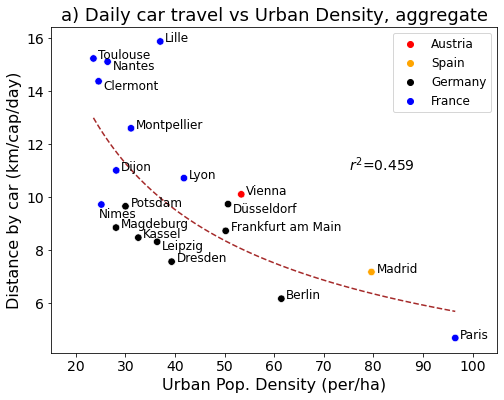

In [11]:
# first with urban area population density
x=df_car_travel['UrbPop Density']
y=df_car_travel['Daily_Travel_cap']
n=100

# now also specify log-log model
# try a log log model
x=np.log(df_car_travel['UrbPop Density'].astype(float))
y=np.log(df_car_travel['Daily_Travel_cap'].astype(float))

z_r = np.polyfit(x, y, 1)
p_r = np.poly1d(z_r)
x_fitted = np.linspace(np.min(x), np.max(x), n)
y_r_fit=p_r(x_fitted)
Slope_log=z_r[0]

r2_log=r2_score(df_car_travel['Daily_Travel_cap'],np.exp(p_r(x)))

y_r_fit_trans=np.exp(y_r_fit)
x_fit_trans=np.exp(x_fitted)

xy_log=pd.DataFrame({'x_fit':x_fit_trans,'y_fit':y_r_fit_trans,'R2':r2_log,'Slope/Beta':Slope_log})

colors=['blue','black','orange','red']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(ax=ax,x='UrbPop Density', y='Daily_Travel_cap', data=df_car_travel, hue='Country',alpha=1,s=55)
#sns.lineplot(x='x_fit', y='y_fit', data=xy,alpha=1,color='green',linestyle="dashed")
sns.lineplot(x='x_fit', y='y_fit', data=xy_log,alpha=1,color='brown',linestyle="dashed")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlim(15, 105)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.0),fontsize=12)
for i, l in enumerate (df_car_travel['City']):
    #plt.annotate(l, (df_car_travel['UrbPop Density'][i]+100, df_car_travel['Daily_Travel_cap'][i]), fontsize=12)
    if l=='Nimes':
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]-.50, df_car_travel['Daily_Travel_cap'][i]-0.5), fontsize=12)
    elif l== ['Toulouse','Potsdam','Vienna','Magdeburg']:
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]-.50, df_car_travel['Daily_Travel_cap'][i]+0.25), fontsize=12)
    elif l in ['Clermont','Leipzig','Nantes','Düsseldorf']:
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]+1, df_car_travel['Daily_Travel_cap'][i]-0.3), fontsize=12)        
    else:
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]+1, df_car_travel['Daily_Travel_cap'][i]), fontsize=12)
plt.title('a) Daily car travel vs Urban Density, aggregate',fontsize=18)
plt.xlabel('Urban Pop. Density (per/ha)',fontsize=16)
plt.ylabel('Distance by car (km/cap/day)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.annotate('$r^2$='+round(r2_log,3).astype(str),(75,11),fontsize=14)
plt.savefig('../figures/summary_all/Daily_car_travel_vs_Density_agg_log.png',facecolor='w',dpi=300,bbox_inches='tight')

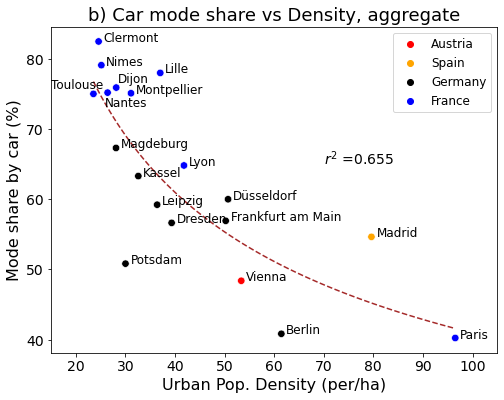

In [13]:
# mode share vs urban pop density
x=df_car_travel['UrbPop Density']
y=df_car_travel['Mode_Share']
n=100
# x_fitted = np.linspace(np.min(x), np.max(x), n)

# a=np.exp(np.polyfit(x, np.log(y), 1)[1])
# b=np.polyfit(x, np.log(y), 1)[0]
# y_fit=a * np.exp(b * x_fitted)

# r2=r2_score(y, a * np.exp(b * x))
# Slope=b
# xy=pd.DataFrame({'x_fit':x_fitted,'y_fit':y_fit,'R2':r2,'Slope/Beta':Slope})

# now also specify log-log model
# try a log log model
x=np.log(df_car_travel['UrbPop Density'].astype(float))
y=np.log(df_car_travel['Mode_Share'].astype(float))

z_r = np.polyfit(x, y, 1)
p_r = np.poly1d(z_r)
x_fitted = np.linspace(np.min(x), np.max(x), n)
y_r_fit=p_r(x_fitted)
Slope_log=z_r[0]
r2_log=r2_score(df_car_travel['Mode_Share'],np.exp(p_r(x)))

y_r_fit_trans=np.exp(y_r_fit)
x_fit_trans=np.exp(x_fitted)

xy_log=pd.DataFrame({'x_fit':x_fit_trans,'y_fit':y_r_fit_trans,'R2':r2_log,'Slope/Beta':Slope_log})

colors=['blue','black','orange','red']
sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(ax=ax,x='UrbPop Density', y='Mode_Share', data=df_car_travel, hue='Country',alpha=1,s=55)
sns.lineplot(x='x_fit', y='y_fit', data=xy_log,alpha=1,color='brown',linestyle="dashed")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlim(15, 105)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.0),fontsize=12)
for i, l in enumerate (df_car_travel['City']):
    if l=='Nantes':
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]-.50, df_car_travel['Mode_Share'][i]-2), fontsize=12)
    elif l== 'Toulouse':
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]-8.5, df_car_travel['Mode_Share'][i]+0.8), fontsize=12)
    elif l== 'Dijon':
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]+.40, df_car_travel['Mode_Share'][i]+0.8), fontsize=12)            
    else:
        plt.annotate(l, (df_car_travel['UrbPop Density'][i]+1, df_car_travel['Mode_Share'][i]), fontsize=12)

plt.title('b) Car mode share vs Density, aggregate',fontsize=18)
plt.xlabel('Urban Pop. Density (per/ha)',fontsize=16)
plt.ylabel('Mode share by car (%)',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.annotate('$r^2$ ='+round(r2_log,3).astype(str),(70,65),fontsize=14)
plt.savefig('../figures/summary_all/Car_mode_share_vs_UrbDensity_agg_log.png',facecolor='w',dpi=300,bbox_inches='tight')

In [16]:
cities=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien']
countries=['Germany','Germany','Germany','Germany','Germany','Germany','Germany','Germany','France','France','France','France','France','France','France','France','France','Spain','Austria']

In [14]:
# function to plot figures mapping key metrics by postcode (or similar) for all cities
def get_data(city):
    print(city)
    country=countries[cities.index(city)]

    if country == 'Germany':
        # original source for postcode shapes for DE is https://www.suche-postleitzahl.org/downloads, the 5stelling.shp, downloaded Jun 8 2022
        fp='../../sufficcs_mobility/source/GTFS/postcodes_gpkg_all/'+city+'_postcodes'+'.gpkg'
        city_map=gpd.read_file(fp)
        city_map.loc[:,'city']=city
        city_map.loc[:,'Country']=country
        city_map['geocode']=city_map['geocode'].astype(str).str.zfill(5)
        dens=pd.read_csv('../outputs/density_geounits/'+city+'_pop_density.csv',dtype={'geocode':str})
        lu=pd.read_csv('../outputs/LU/UA_' + city + '.csv',dtype={'geocode':str})
        city_map=city_map.merge(dens.loc[:,['geocode','Density']])
        city_map=city_map.merge(lu.loc[:,['geocode','pc_urban']])
        
        if city == 'Berlin': # for Berlin, first in the loop, initiate the city_map_all df, and set the scaling factor based on Berlin. This will allow plots to be on comparabale scales later.
            global city_map_all
            city_map_all=city_map.copy()
            xex=city_map.total_bounds[2]-city_map.total_bounds[0]
            yex=city_map.total_bounds[3]-city_map.total_bounds[1]
            global scale 
            scale=xex/14

            stats=pd.read_csv('../outputs/Summary_geounits/'+city+'.csv',dtype={'Res_geocode':str})
            stats['Res_geocode']=stats.loc[:,'Res_geocode'].astype('str')
            stats.iloc[:,[1,2,3,4,5,8]]=stats.iloc[:,[1,2,3,4,5,8]]*100 # convert shares to %
            stats.fillna(0,inplace=True)
            city_stats=city_map.merge(stats,how='left',left_on='geocode',right_on='Res_geocode')
            city_stats.dropna(subset='Res_geocode',inplace=True)

            d2c=pd.read_csv('../outputs/CenterSubcenter/Berlin_dist.csv',dtype={'plz':str,'geocode':str})
            if 'plz' in d2c.columns:
                d2c.rename(columns={'plz':'geocode'},inplace=True)
            d2c['geocode']=d2c['geocode'].astype(str)

            city_stats=city_stats.merge(d2c,how='left',left_on='geocode',right_on='geocode')

            global city_stats_all
            city_stats_all=city_stats.copy()

        else:
            city_map_all=pd.concat([city_map_all,city_map])
            xex=city_map.total_bounds[2]-city_map.total_bounds[0]
            yex=city_map.total_bounds[3]-city_map.total_bounds[1]

            stats=pd.read_csv('../outputs/Summary_geounits/'+city+'.csv',dtype={'Res_geocode':str})
            stats['Res_geocode']=stats.loc[:,'Res_geocode'].astype('str')
            stats.iloc[:,[1,2,3,4,5,8]]=stats.iloc[:,[1,2,3,4,5,8]]*100 # convert shares to %
            stats.fillna(0,inplace=True)
            city_stats=city_map.merge(stats,how='left',left_on='geocode',right_on='Res_geocode')

            d2c=pd.read_csv('../outputs/CenterSubcenter/' + city + '_dist.csv',dtype={'plz':str,'geocode':str})
            if 'plz' in d2c.columns:
                d2c.rename(columns={'plz':'geocode'},inplace=True)
            d2c['geocode']=d2c['geocode'].astype(str)
            city_stats=city_stats.merge(d2c,how='left',left_on='geocode',right_on='geocode')
            city_stats_all=pd.concat([city_stats_all,city_stats])

    if country in ['France', 'Spain','Austria']:
        
        if city =='Wien': city_map=import_csv_w_wkt_to_gdf('../outputs/density_geounits/'+city+'_pop_density.csv',crs=crs0,gc='geocode') #; city_map.rename(columns={'geocode':'geo_unit'},inplace=True)
        elif city == 'Paris': city_map=import_csv_w_wkt_to_gdf('../outputs/density_geounits/'+city+'_pop_density_lowres.csv',crs=crs0,gc='geo_unit'); city_map.rename(columns={'geo_unit':'geocode'},inplace=True)
        else: city_map=import_csv_w_wkt_to_gdf('../outputs/density_geounits/'+city+'_pop_density_lowres.csv',crs=crs0,gc='geocode'); city_map.rename(columns={'geo_unit':'geocode'},inplace=True)

        city_map['geocode']=city_map.loc[:,'geocode'].astype(str)
        city_map.loc[:,'city']=city
        city_map.loc[:,'Country']=country
        if city in ['Wien','Paris']:
            lu=pd.read_csv('../outputs/LU/UA_' + city + '.csv',dtype={'geocode':str})
        else:
            lu=pd.read_csv('../outputs/LU/UA_' + city + '_lowres.csv',dtype={'geocode':str})
        city_map=city_map.merge(lu.loc[:,['geocode','pc_urban']])

        city_map_all=pd.concat([city_map_all,city_map])
        xex=city_map.total_bounds[2]-city_map.total_bounds[0]
        yex=city_map.total_bounds[3]-city_map.total_bounds[1]

        if city in ['Paris','Wien']:  stats=pd.read_csv('../outputs/Summary_geounits/'+city+'.csv')#; stats.rename(columns={'Res_geocode':'geocode'},inplace=True) #2nd part Paris only
        else: 
            stats=pd.read_csv('../outputs/Summary_geounits/'+city+'_agg.csv')
            stats.rename(columns={'Res_geo_unit':'Res_geocode'},inplace=True)
            #stats.rename(columns={'geocode':'geo_unit'},inplace=True)
        stats['Res_geocode']=stats['Res_geocode'].astype(str)

        stats.iloc[:,[1,2,3,4,5,8]]=stats.iloc[:,[1,2,3,4,5,8]]*100 # convert shares to %
        stats.fillna(0,inplace=True)
        city_stats=city_map.merge(stats,how='left',left_on='geocode',right_on='Res_geocode')
        city_stats.dropna(subset='Res_geocode',inplace=True)

        if city in ['Paris','Wien']: d2c=pd.read_csv('../outputs/CenterSubcenter/' + city + '_dist.csv',dtype={'plz':str,'geocode':str})
        else: d2c=pd.read_csv('../outputs/CenterSubcenter/' + city + '_dist_lowres.csv') # here 
        d2c['geocode']=d2c['geocode'].astype(str)
        city_stats=city_stats.merge(d2c,how='left',left_on='geocode',right_on='geocode')
        city_stats_all=pd.concat([city_stats_all,city_stats])

    print('Finished gathering stats for ' + city)

In [17]:
cities_all=pd.Series(cities)
cities_all.apply(get_data)

Berlin
Finished gathering stats for Berlin
Dresden
Finished gathering stats for Dresden
Düsseldorf
Finished gathering stats for Düsseldorf
Frankfurt am Main
Finished gathering stats for Frankfurt am Main
Kassel
Finished gathering stats for Kassel
Leipzig
Finished gathering stats for Leipzig
Magdeburg
Finished gathering stats for Magdeburg
Potsdam
Finished gathering stats for Potsdam
Clermont
Finished gathering stats for Clermont
Dijon
Finished gathering stats for Dijon
Lille
Finished gathering stats for Lille
Lyon
Finished gathering stats for Lyon
Montpellier
Finished gathering stats for Montpellier
Nantes
Finished gathering stats for Nantes
Nimes
Finished gathering stats for Nimes
Paris
Finished gathering stats for Paris
Toulouse
Finished gathering stats for Toulouse
Madrid
Finished gathering stats for Madrid
Wien
Finished gathering stats for Wien


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
dtype: object

In [18]:
city_stats_all['Urb_Density']=city_stats_all['Density']/city_stats_all['pc_urban']
city_map_all['Urb_Density']=city_map_all['Density']/city_map_all['pc_urban']


In [19]:
# now make summary figures and models of key variables from all cities
city_stats_df=pd.DataFrame(city_stats_all.drop(columns='geometry'))
df=city_stats_df.dropna(subset=('Daily_Distance_Person_Car','Density','Urb_Density','Distance2Center','Share_Distance_Car')).copy()
df=df.loc[:,('Country','city' ,'Daily_Distance_Person_Car','Density','Urb_Density','Distance2Center','Share_Distance_Car')]
df=df.loc[df['Daily_Distance_Person_Car']>0,:]
df.reset_index(drop=True,inplace=True)

df['Region']=df['city'].copy()
df.loc[(df['Country']=='France') & (df['city']!='Paris'),'Region']='FR_Other'
df.loc[(df['Country']=='Germany') & (df['city']!='Berlin'),'Region']='DE_Other'
regions=df['Region'].unique()
df.loc[:,['Density','Urb_Density']]=0.01*df.loc[:,['Density','Urb_Density']]
labs={'Daily_Distance_Person_Car':'Distance by Car (km/cap/day)','Density':'Density (per/ha)','Urb_Density':'Urban Pop. Density (per/ha)', 'Distance2Center':'Distance to Center (km)','Share_Distance_Car':'Mode Share by Car (%)'}

sns.set_palette(sns.color_palette('tab10'))
df['city']=df['city'].replace({'Wien':'Vienna'})
df['Region']=df['Region'].replace({'Wien':'Vienna'})
regions=df['Region'].unique()

In [20]:
# plot function
def plot_all(variables,rel,title):
    y=variables.split('*')[0]
    x=variables.split('*')[1]
    n=100
    # x_fitted = np.linspace(np.min(df[x]), np.max(df[x]), n)
    # xlog=np.log(df[x].astype(float))
    # x_fitted_log = np.linspace(np.min(xlog), np.max(xlog), n)
    xy=pd.DataFrame(columns = ['Region','x_fit','y_fit','R2','Slope/Beta','Type'])
    xy_loglin=pd.DataFrame(columns = ['Region','x_fit','y_fit','R2','Slope/Beta','Type'])
    xy_loglog=pd.DataFrame(columns = ['Region','x_fit','y_fit','R2','Slope/Beta','Type'])
    #type=rel

    for r in regions:
        
        if r == 'All':
            x_r=df[x]
            y_r=df[y]
        else:
            x_r=df.loc[df['Region']==r,x]
            y_r=df.loc[df['Region']==r,y]
            x_fitted = np.linspace(np.min(x_r), np.max(x_r), n)
            xlog=np.log(x_r.astype(float))
            x_fitted_log = np.linspace(np.min(xlog), np.max(xlog), n)

        if rel=='lin':
            z_r = np.polyfit(x_r, y_r, 1)
            p_r = np.poly1d(z_r)
            y_r_fit=p_r(x_fitted)
            r2_r=r2_score(y_r, p_r(x_r))
            Slope=z_r[0]
            xy_r=pd.DataFrame({'Region':r,'x_fit':x_fitted,'y_fit':y_r_fit,'R2':r2_r,'Slope/Beta':Slope,'Type':'lin'})

            xy=pd.concat([xy,xy_r])

        if rel=='exp':
            # exp fit
            a_r=np.exp(np.polyfit(x_r, np.log(y_r), 1)[1])
            b_r=np.polyfit(x_r, np.log(y_r), 1)[0]
            y_r_fit=a_r * np.exp(b_r * x_fitted)

            r2_r=r2_score(y_r, a_r * np.exp(b_r * x_r))
            Slope=b_r
            xy_r=pd.DataFrame({'Region':r,'x_fit':x_fitted,'y_fit':y_r_fit,'R2':r2_r,'Slope/Beta':Slope,'Type':'log-lin'})
            xy_loglin=pd.concat([xy_loglin,xy_r])

            # log log fit
            xl=np.log(x_r.astype(float))
            yl=np.log(y_r.astype(float))    
            z_r = np.polyfit(xl, yl, 1)
            p_r = np.poly1d(z_r)
            #x_fitted_log = np.linspace(np.min(xl), np.max(xl), n)
            y_r_fit=p_r(x_fitted_log)
            Slope_log=z_r[0]
            r2_log=r2_score(y_r,np.exp(p_r(xl)))

            y_r_fit_trans=np.exp(y_r_fit)
            x_fit_trans=np.exp(x_fitted_log)

            xy_log=pd.DataFrame({'Region':r,'x_fit':x_fit_trans,'y_fit':y_r_fit_trans,'R2':r2_log,'Slope/Beta':Slope_log,'Type':'log-log'})
            xy_loglog=pd.concat([xy_loglog,xy_log])

            if r2_log>r2_r:
                xy=pd.concat([xy,xy_log])
                print(r,'log-log is better')

            elif r2_r>r2_log:
                xy=pd.concat([xy,xy_r])
                print(r,'logy is better')

    xy.reset_index(drop=True,inplace=True)
    xy['Region']=xy['Region'].str.replace('_O',', o')
    if rel=='exp':
        xy['Region_R2']=xy['Region'] + ', $r^2$=' + xy['R2'].map(lambda x: round(x,2)).astype(str) + ', ' + xy['Type']
    else:
        xy['Region_R2']=xy['Region'] + ', $r^2$=' + xy['R2'].map(lambda x: round(x,2)).astype(str)

    fig, ax = plt.subplots(figsize=(8,6))
    sns.scatterplot(ax=ax,x=x, y=y, data=df, hue='Region',alpha=0.4,s=30,legend=False)
    sns.lineplot(x='x_fit', y='y_fit', data=xy, hue='Region_R2',alpha=1)
    if y=='Daily_Distance_Person_Car':
        ax.set_ylim(0, 40)

    if y=='Share_Distance_Car':
        ax.set_ylim(0,102)
        
    if x=='Urb_Density':
        ax.xaxis.set_ticks(np.arange(0, 450, 50))

    plt.title(title,fontsize=18)
    plt.xlabel(labs[x],fontsize=16)
    plt.ylabel(labs[y],fontsize=16)#
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 1.0),fontsize=12,labelspacing = 0.1)
    #plt.show()
    #plt.savefig('../figures/summary_all/' + title + '_' + rel + '_log.png',facecolor='w',dpi=300,bbox_inches='tight')

    print('R2:')
    print(round(xy.groupby('Region')['R2'].mean(),3))
    print('Slopes:')
    print(round(xy.groupby('Region')['Slope/Beta'].mean(),6))

    ret = pd.DataFrame(xy.groupby('Region')['R2'].mean()).reset_index().merge(pd.DataFrame(xy.groupby('Region')['Slope/Beta'].mean()).reset_index()).merge(pd.DataFrame(xy.groupby('Region')['Type'].first()).reset_index())
    ret['Relationship']=title
    ret['Model']=rel

    ret_loglin = pd.DataFrame(xy_loglin.groupby('Region')['R2'].mean()).reset_index().merge(pd.DataFrame(xy_loglin.groupby('Region')['Slope/Beta'].mean()).reset_index()).merge(pd.DataFrame(xy_loglin.groupby('Region')['Type'].first()).reset_index())
    ret_loglin['Relationship']=title
    ret_loglin['Model']=rel

    ret_loglog = pd.DataFrame(xy_loglog.groupby('Region')['R2'].mean()).reset_index().merge(pd.DataFrame(xy_loglog.groupby('Region')['Slope/Beta'].mean()).reset_index()).merge(pd.DataFrame(xy_loglog.groupby('Region')['Type'].first()).reset_index())
    ret_loglog['Relationship']=title
    ret_loglog['Model']=rel

    return ret, xy, ret_loglin, ret_loglog

Berlin logy is better
DE_Other logy is better
FR_Other log-log is better
Paris log-log is better
Madrid logy is better
Vienna log-log is better
R2:
Region
Berlin       0.454
DE, other    0.083
FR, other    0.598
Madrid       0.503
Paris        0.437
Vienna       0.418
Name: R2, dtype: float64
Slopes:
Region
Berlin      -0.006511
DE, other   -0.004039
FR, other   -0.468143
Madrid      -0.003359
Paris       -0.507249
Vienna      -0.495791
Name: Slope/Beta, dtype: float64


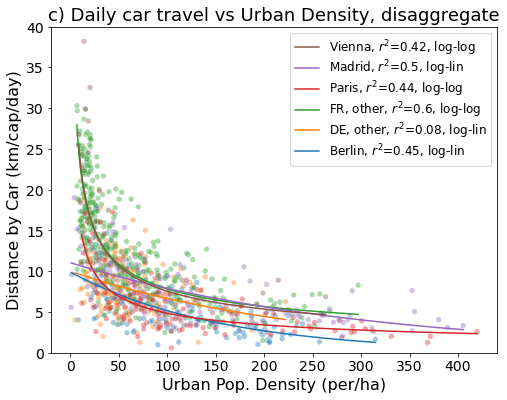

In [21]:
car_dist_vs_density_exp, xy, ret_loglin, ret_loglog =plot_all('Daily_Distance_Person_Car*Urb_Density','exp','c) Daily car travel vs Urban Density, disaggregate')

In [22]:
ret_loglin

,Region,R2,Slope/Beta,Type,Relationship,Model
0,Berlin,0.454386,-0.006511,log-lin,"c) Daily car travel vs Urban Density, disaggre...",exp
1,DE_Other,0.082578,-0.004039,log-lin,"c) Daily car travel vs Urban Density, disaggre...",exp
2,FR_Other,0.535405,-0.006943,log-lin,"c) Daily car travel vs Urban Density, disaggre...",exp
3,Madrid,0.502736,-0.003359,log-lin,"c) Daily car travel vs Urban Density, disaggre...",exp
4,Paris,0.328442,-0.004231,log-lin,"c) Daily car travel vs Urban Density, disaggre...",exp
5,Vienna,0.302344,-0.006537,log-lin,"c) Daily car travel vs Urban Density, disaggre...",exp


In [23]:
round(ret_loglin['R2'],3)

0    0.454
1    0.083
2    0.535
3    0.503
4    0.328
5    0.302
Name: R2, dtype: float64

Berlin logy is better
DE_Other logy is better
FR_Other logy is better
Paris log-log is better
Madrid logy is better
Vienna log-log is better
R2:
Region
Berlin       0.463
DE, other    0.140
FR, other    0.619
Madrid       0.591
Paris        0.458
Vienna       0.276
Name: R2, dtype: float64
Slopes:
Region
Berlin      -0.004350
DE, other   -0.002818
FR, other   -0.003316
Madrid      -0.001658
Paris       -0.337256
Vienna      -0.197994
Name: Slope/Beta, dtype: float64


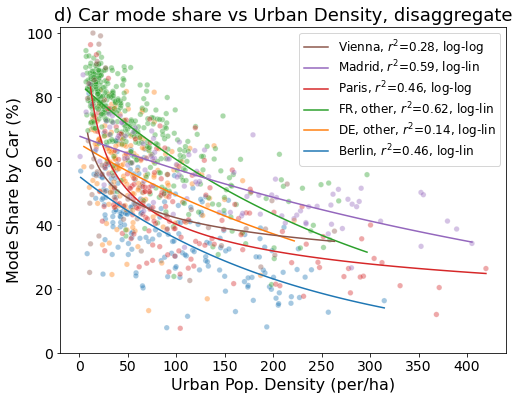

In [24]:
car_share_vs_density_exp,xy, ret_loglin, ret_loglog =plot_all('Share_Distance_Car*Urb_Density','exp','d) Car mode share vs Urban Density, disaggregate')

R2:
Region
Berlin       0.666
DE, other    0.221
FR, other    0.521
Madrid       0.464
Paris        0.542
Vienna       0.390
Name: R2, dtype: float64
Slopes:
Region
Berlin       0.617135
DE, other    0.594597
FR, other    1.086896
Madrid       0.369097
Paris        0.522431
Vienna       1.456314
Name: Slope/Beta, dtype: float64


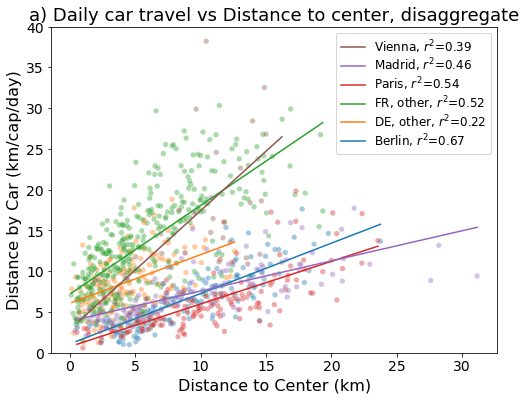

In [25]:
car_dist_vs_d2c_lin,a,b,c=plot_all('Daily_Distance_Person_Car*Distance2Center','lin','a) Daily car travel vs Distance to center, disaggregate')

In [26]:
car_dist_vs_d2c_lin

,Region,R2,Slope/Beta,Type,Relationship,Model
0,Berlin,0.665776,0.617135,lin,"a) Daily car travel vs Distance to center, dis...",lin
1,"DE, other",0.221425,0.594597,lin,"a) Daily car travel vs Distance to center, dis...",lin
2,"FR, other",0.521156,1.086896,lin,"a) Daily car travel vs Distance to center, dis...",lin
3,Madrid,0.464075,0.369097,lin,"a) Daily car travel vs Distance to center, dis...",lin
4,Paris,0.541920,0.522431,lin,"a) Daily car travel vs Distance to center, dis...",lin
5,Vienna,0.390220,1.456314,lin,"a) Daily car travel vs Distance to center, dis...",lin


R2:
Region
Berlin       0.431
DE, other    0.145
FR, other    0.260
Madrid       0.351
Paris        0.433
Vienna       0.292
Name: R2, dtype: float64
Slopes:
Region
Berlin       2.058883
DE, other    1.896498
FR, other    1.814493
Madrid       1.084745
Paris        2.095266
Vienna       2.420081
Name: Slope/Beta, dtype: float64


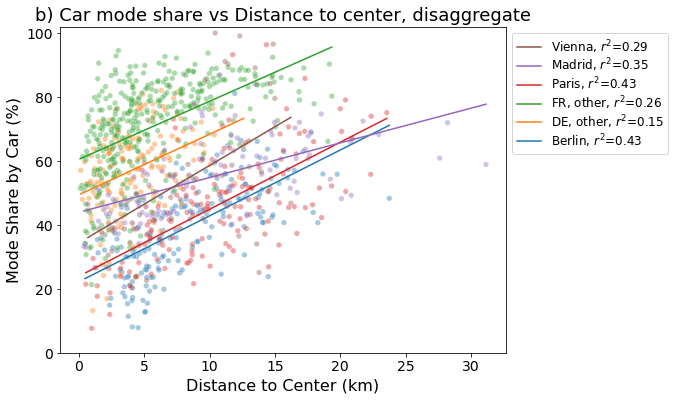

In [27]:
car_share_vs_d2c_lin,a,b,c=plot_all('Share_Distance_Car*Distance2Center','lin','b) Car mode share vs Distance to center, disaggregate')

In [28]:
car_share_vs_d2c_lin

,Region,R2,Slope/Beta,Type,Relationship,Model
0,Berlin,0.431025,2.058883,lin,"b) Car mode share vs Distance to center, disag...",lin
1,"DE, other",0.145265,1.896498,lin,"b) Car mode share vs Distance to center, disag...",lin
2,"FR, other",0.259677,1.814493,lin,"b) Car mode share vs Distance to center, disag...",lin
3,Madrid,0.350633,1.084745,lin,"b) Car mode share vs Distance to center, disag...",lin
4,Paris,0.433135,2.095266,lin,"b) Car mode share vs Distance to center, disag...",lin
5,Vienna,0.291601,2.420081,lin,"b) Car mode share vs Distance to center, disag...",lin
